# **ALEX**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Running on :  cpu
Epochs 1/3
----------
train loss: 1.3865 Acc: 0.2475
test loss: 1.3863 Acc: 0.2500

Epochs 2/3
----------
train loss: 1.3864 Acc: 0.2525
test loss: 1.3862 Acc: 0.2500

Epochs 3/3
----------
train loss: 1.3859 Acc: 0.2500
test loss: 1.3861 Acc: 0.2500

Training complete in 2m 33s
Best Test acc : 0.25


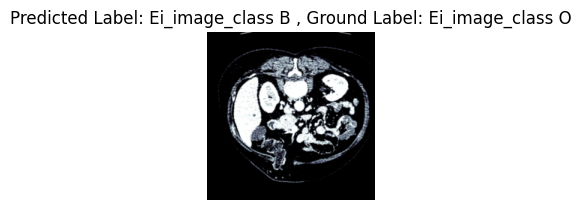

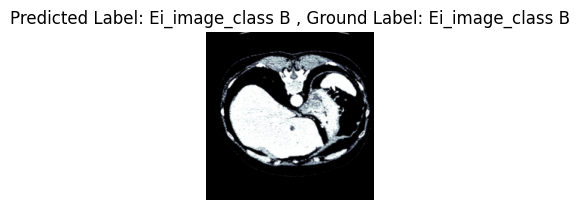

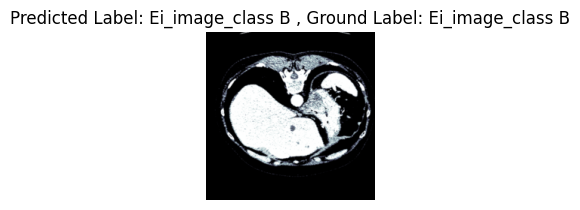

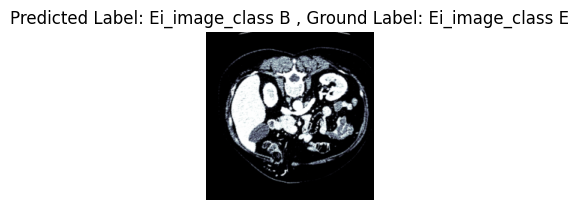

Epochs 1/3
----------
train loss: 2.3027 Acc: 0.0300
test loss: 2.2975 Acc: 0.0000

Epochs 2/3
----------
train loss: 2.2963 Acc: 0.1175
test loss: 2.2869 Acc: 0.2425

Epochs 3/3
----------
train loss: 2.2843 Acc: 0.2500
test loss: 2.2721 Acc: 0.2425

Training complete in 1m 33s
Best Test acc : 0.2425


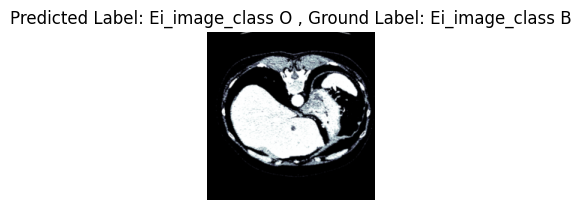

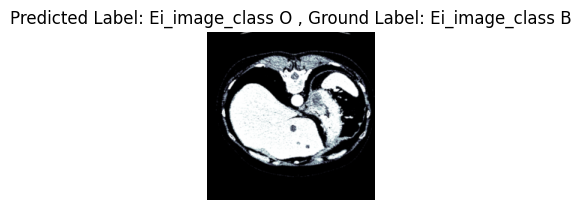

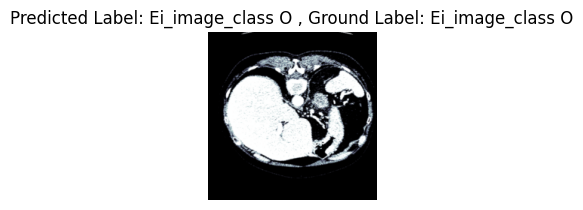

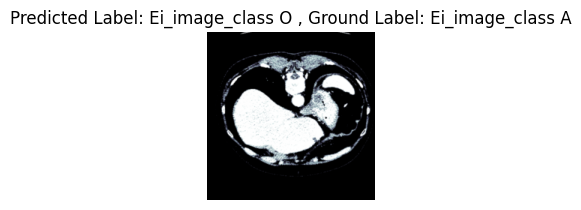

In [ ]:
mydict =[]

import torch
from torch import nn
class AlexNet(nn.Module):

    def __init__(self, num_classes = 4): # Number of Output classes are set to 10 as there exists 10 differnet classes in the presented dataset
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024), # (4096, 4096) --> (4096, 1024) to avoid overfitting and heavy losses during training
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )


    def forward(self, x):
        '''
        Parameters
        ----------
        x : Input Image
            An Input image of size 256x256x3.

        Returns
        -------
        x : Output Tensor
            Flattened 1-Dimensional Tensor providing scores for 6 classes.

        '''
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#####################################################
## Train & Test
########Generic Modules########
import torch
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time
import os
import copy



########User-Defined Modules########
class ANTL:

    def __init__(self):

        self.data_transforms = {
                                'train' : transforms.Compose([
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ]),
                                'test' : transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
                                }
        self.data_dir = '/content/drive/MyDrive/GP Dataset' #Paste the address of the folder involving your dataset
        self.image_datasets = {x : datasets.ImageFolder(os.path.join(self.data_dir, x),
                                           self.data_transforms[x])
                                    for x in ['train', 'test']}
        self.dataloaders = {x : torch.utils.data.DataLoader(self.image_datasets[x], batch_size=256,
                                                shuffle=True)
                                    for x in ['train', 'test']}
        self.dataset_sizes = {x: len(self.image_datasets[x]) for x in ['train', 'test']}
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.epochs = 3
        self.criterion = torch.nn.CrossEntropyLoss()
        print("Running on : ", self.device)
        self.class_names = self.image_datasets['train'].classes


    def train(self, model, criterion, optimizer):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        for epoch in range(self.epochs):
            print('Epochs {}/{}'.format(epoch + 1, self.epochs))
            print('-' * 10)

            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train() # set model to training mode
                else:
                    model.eval() # set model to validation mode

                running_loss = 0.0
                running_corrects = 0
                #Iterate over data
                for inputs, labels in self.dataloaders[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / self.dataset_sizes[phase]
                epoch_acc = running_corrects.double() / self.dataset_sizes[phase]
                print('{} loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed%60))
        print('Best Test acc : {}'.format(best_acc))

        model.load_state_dict(best_model_wts)
        return model


    def pretrain(self):
        model_pt = AlexNet().to(self.device)
        op = optim.SGD(model_pt.parameters(), lr=0.01, momentum=0.9)
        pt = self.train(model_pt, self.criterion, op)
        self.visualize(pt)
        return pt


    def fine_tune(self):
        model_ft = self.pretrain()
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = torch.nn.Linear(num_ftrs, 10)
        model_ft = model_ft.to(self.device)
        op = optim.SGD(model_ft.classifier[6].parameters(), lr=0.01, momentum=0.9)
        ft = self.train(model_ft, self.criterion, op)
        self.visualize(ft)


    def visualize(self, model, num_images=4):
        def imshow(inp,title = None):
            inp = inp.numpy().transpose((1,2,0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1) # limits the values in an array btn range [0,1]
            plt.imshow(inp)
            if title is not None:
                plt.title(title)
            plt.pause(0.0001)
        was_training = model.training
        model.eval()
        images_so_far = 0
        fig = plt.figure()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(self.dataloaders['test']):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = model(inputs.to(self.device))
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('Predicted Label: {} , Ground Label: {}'.format(self.class_names[preds[j]], self.class_names[labels[j]]))

                    if(self.class_names[preds[j]] == 'A'):
                      print(j,'png')
                      mydict.append([str(j)+ '.png', 0])

                    if(self.class_names[preds[j]] == 'B'):
                      print(j, 'png')
                      mydict.append([str(j)+ '.png', 1])

                    if(self.class_names[preds[j]] == '0'):
                      print(j, 'png')
                      mydict.append([str(j)+ '.png', 2])

                    if(self.class_names[preds[j]] == 'E'):
                      print(j, 'png')

                      mydict.append([str(j)+ '.png', 3])




                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
            model.train(mode=was_training)

result = ANTL()
result.fine_tune()

import csv

# my data rows as dictionary objects


# field names
fields = ['image_name', 'label']

# name of csv file
filename = "AlexNet.csv"

# writing to csv file
with open(filename, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)

    # writing the fields
    csvwriter.writerow(fields)

    # writing the data rows
    csvwriter.writerows(mydict)

# ***AlexNet Model***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
class AlexNet(nn.Module):

    def __init__(self, num_classes = 4): # Number of Output classes are set to 10 as there exists 10 differnet classes in the presented dataset
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024), # (4096, 4096) --> (4096, 1024) to avoid overfitting and heavy losses during training
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )


    def forward(self, x):
        '''
        Parameters
        ----------
        x : Input Image
            An Input image of size 256x256x3.

        Returns
        -------
        x : Output Tensor
            Flattened 1-Dimensional Tensor providing scores for 6 classes.

        '''
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
########Generic Modules########
import torch
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time
import os
import copy

In [ ]:
mydict =[]

########User-Defined Modules########
class ANTL:

    def __init__(self):

        self.data_transforms = {
                                'train' : transforms.Compose([
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ]),
                                'test' : transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
                                }
        self.data_dir = '/content/drive/MyDrive/GP Dataset' #Paste the address of the folder involving your dataset
        self.image_datasets = {x : datasets.ImageFolder(os.path.join(self.data_dir, x),
                                           self.data_transforms[x])
                                    for x in ['train', 'test']}
        self.dataloaders = {x : torch.utils.data.DataLoader(self.image_datasets[x], batch_size=256,
                                                shuffle=True)
                                    for x in ['train', 'test']}
        self.dataset_sizes = {x: len(self.image_datasets[x]) for x in ['train', 'test']}
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.epochs = 3
        self.criterion = torch.nn.CrossEntropyLoss()
        print("Running on : ", self.device)
        self.class_names = self.image_datasets['train'].classes


    def train(self, model, criterion, optimizer):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        for epoch in range(self.epochs):
            print('Epochs {}/{}'.format(epoch + 1, self.epochs))
            print('-' * 10)

            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train() # set model to training mode
                else:
                    model.eval() # set model to validation mode

                running_loss = 0.0
                running_corrects = 0
                #Iterate over data
                for inputs, labels in self.dataloaders[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / self.dataset_sizes[phase]
                epoch_acc = running_corrects.double() / self.dataset_sizes[phase]
                print('{} loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed%60))
        print('Best Test acc : {}'.format(best_acc))

        model.load_state_dict(best_model_wts)
        return model


    def pretrain(self):
        model_pt = AlexNet().to(self.device)
        op = optim.SGD(model_pt.parameters(), lr=0.01, momentum=0.9)
        pt = self.train(model_pt, self.criterion, op)
        self.visualize(pt)
        return pt


    def fine_tune(self):
        model_ft = self.pretrain()
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[4].in_features
        model_ft.classifier[4] = torch.nn.Linear(num_ftrs, 10)
        model_ft = model_ft.to(self.device)
        op = optim.SGD(model_ft.classifier[4].parameters(), lr=0.01, momentum=0.9)
        ft = self.train(model_ft, self.criterion, op)
        self.visualize(ft)


    def visualize(self, model, num_images=4):
        def imshow(inp,title = None):
            inp = inp.numpy().transpose((1,2,0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1) # limits the values in an array btn range [0,1]
            plt.imshow(inp)
            if title is not None:
                plt.title(title)
            plt.pause(0.0001)
        was_training = model.training
        model.eval()
        images_so_far = 0
        fig = plt.figure()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(self.dataloaders['test']):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = model(inputs.to(self.device))
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('Predicted Label: {} , Ground Label: {}'.format(self.class_names[preds[j]], self.class_names[labels[j]]))

                    if(self.class_names[preds[j]] == 'A'):
                      print(j,'png')
                      mydict.append([str(j)+ '.png', 0])

                    if(self.class_names[preds[j]] == 'B'):
                      print(j, 'png')
                      mydict.append([str(j)+ '.png', 1])

                    if(self.class_names[preds[j]] == '0'):
                      print(j, 'png')
                      mydict.append([str(j)+ '.png', 2])

                    if(self.class_names[preds[j]] == 'E'):
                      print(j, 'png')

                      mydict.append([str(j)+ '.png', 3])

                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
            model.train(mode=was_training)

Running on :  cpu
Epochs 1/3
----------
train loss: 1.3867 Acc: 0.2550
test loss: 1.3867 Acc: 0.2500

Epochs 2/3
----------
train loss: 1.3865 Acc: 0.2500
test loss: 1.3866 Acc: 0.2500

Epochs 3/3
----------
train loss: 1.3870 Acc: 0.2575
test loss: 1.3865 Acc: 0.2500

Training complete in 4m 37s
Best Test acc : 0.25


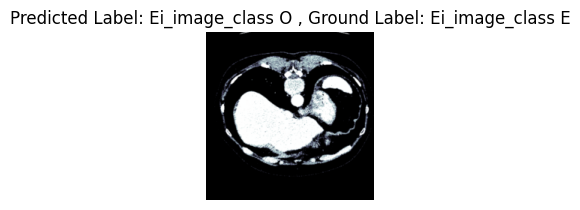

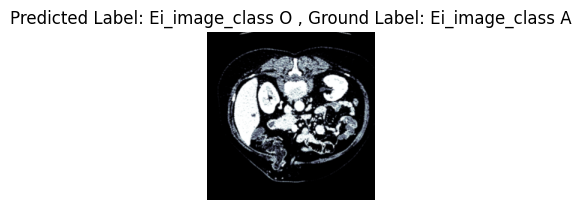

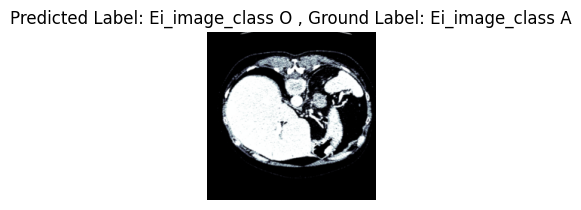

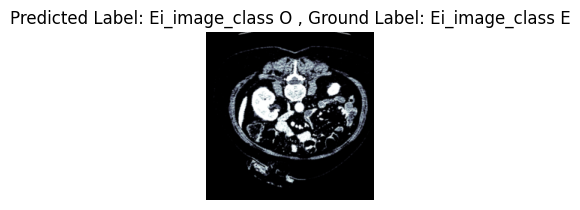

Epochs 1/3
----------


RuntimeError: ignored

In [ ]:
result = ANTL()
result.fine_tune()

In [ ]:
import csv

# field names
fields = ['image_name', 'label']

# name of csv file
filename = "AlexNet.csv"

# writing to csv file
with open(filename, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)

    # writing the fields
    csvwriter.writerow(fields)

    # writing the data rows
    csvwriter.writerows(mydict)

# ***Model 2***

# **Data Prepare**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yaraa01","key":"5d97f3539207bc2644a907443f487e96"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Mar 10 11:10 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/liver-tumor-segmentation

#!kaggle datasets download -d andrewmvd/liver-tumor-segmentation-part-2

100% 4.82G/4.84G [00:44<00:00, 215MB/s]
100% 4.84G/4.84G [00:44<00:00, 117MB/s]


In [ ]:
!unzip liver-tumor-segmentation -d liver-tumor-segmentation

Archive:  liver-tumor-segmentation.zip
  inflating: liver-tumor-segmentation/segmentations/segmentation-0.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-1.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-10.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-100.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-101.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-102.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-103.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-104.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-105.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-106.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-107.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-108.nii  
  inflating: liver-tumor-segmentation/segmentations/segmentation-1

In [ ]:
!rm -rf /content/liver-tumor-segmentation.zip

In [ ]:
!unzip liver-tumor-segmentation-part-2 -d liver-tumor-segmentation-part-2

In [ ]:
!rm -rf /content/liver-tumor-segmentation-part-2.zip

# Remove extra files

In [ ]:
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-100.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-51.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-52.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-53.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-54.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-55.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-56.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-57.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-58.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-59.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-60.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-61.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-62.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-63.nii

!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-64.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-65.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-66.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-67.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-68.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-69.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-70.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-71.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-72.nii
!!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-73.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-74.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-75.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-76.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-77.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-78.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-79.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-80.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-81.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-82.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-83.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-84.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-85.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-86.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-87.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-88.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-89.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-90.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-91.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-92.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-93.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-94.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-95.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-96.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-97.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-98.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt6/volume-99.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-101.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-102.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-103.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-104.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-105.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-106.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-107.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-108.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-109.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-110.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-111.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-112.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-113.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-114.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-115.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-116.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-117.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-118.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-119.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-120.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-121.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-122.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-123.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-124.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-125.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-126.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-127.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-128.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-129.nii
!rm -rf /content/liver-tumor-segmentation-part-2/volume_pt8/volume-130.nii


!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-0.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-1.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-2.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-3.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-4.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-5.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-6.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-7.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-8.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-9.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-10.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-11.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-11.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-12.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-13.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-14.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-15.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-16.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-17.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-18.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-19.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt2/volume-20.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-21.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-22.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-23.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-24.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-25.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-26.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-27.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-28.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-29.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt3/volume-30.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-31.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-32.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-33.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-34.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-35.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-36.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-37.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-38.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-39.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt4/volume-40.nii
#!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-41.nii
#!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-42.nii
#!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-43.nii
#!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-44.nii
#!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-45.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-46.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-47.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-48.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-49.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt5/volume-50.nii

In [ ]:
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-0.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-1.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-2.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-3.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-4.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-5.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-6.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-7.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-8.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-9.nii
!rm -rf /content/liver-tumor-segmentation/volume_pt1/volume-10.nii

In [ ]:
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-0.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-1.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-2.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-3.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-4.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-5.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-6.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-7.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-8.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-9.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-10.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-11.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-12.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-13.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-14.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-15.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-16.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-17.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-18.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-19.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-20.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-21.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-22.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-23.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-24.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-25.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-26.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-27.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-28.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-29.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-30.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-31.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-32.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-33.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-34.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-35.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-36.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-37.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-38.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-39.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-40.nii
#!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-41.nii
#!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-42.nii
#!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-43.nii
#!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-44.nii
#!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-45.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-46.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-47.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-48.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-49.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-50.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-51.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-52.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-53.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-54.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-55.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-56.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-57.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-58.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-59.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-60.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-61.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-62.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-63.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-64.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-65.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-66.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-67.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-68.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-69.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-70.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-71.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-72.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-73.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-74.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-75.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-76.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-77.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-78.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-79.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-80.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-81.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-82.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-83.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-84.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-85.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-86.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-87.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-88.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-89.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-90.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-91.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-92.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-93.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-94.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-95.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-96.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-97.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-98.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-99.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-100.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-101.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-102.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-103.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-104.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-105.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-106.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-107.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-108.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-109.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-110.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-111.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-112.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-113.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-114.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-115.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-116.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-117.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-118.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-119.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-120.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-121.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-122.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-123.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-124.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-125.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-126.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-127.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-128.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-129.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-130.nii
!rm -rf /content/liver-tumor-segmentation/segmentations/segmentation-131.nii

# **Preprocessing**

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

In [ ]:
#!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
#!pip install --upgrade kornia > /dev/null
#!pip install allennlp==1.1.0.rc4 > /dev/null
#!pip install --upgrade fastai > /dev/null
import fastai; fastai.__version__

'2.7.11'

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [ ]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('/content/liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename))

for dirname, _, filenames in os.walk('/content/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname,filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
3,/content/liver-tumor-segmentation/segmentations,segmentation-41.nii
2,/content/liver-tumor-segmentation/segmentations,segmentation-42.nii
0,/content/liver-tumor-segmentation/segmentations,segmentation-43.nii
4,/content/liver-tumor-segmentation/segmentations,segmentation-44.nii
1,/content/liver-tumor-segmentation/segmentations,segmentation-45.nii
9,/content/liver-tumor-segmentation/volume_pt5,volume-41.nii
5,/content/liver-tumor-segmentation/volume_pt5,volume-42.nii
8,/content/liver-tumor-segmentation/volume_pt5,volume-43.nii
6,/content/liver-tumor-segmentation/volume_pt5,volume-44.nii
7,/content/liver-tumor-segmentation/volume_pt5,volume-45.nii


In [ ]:
# Map CT scan and label

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "/content/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)
print(len(df_files))
df_files

5


,dirname,filename,mask_dirname,mask_filename
0,/content/liver-tumor-segmentation/volume_pt5,volume-41.nii,/content/liver-tumor-segmentation/segmentations,segmentation-41.nii
1,/content/liver-tumor-segmentation/volume_pt5,volume-42.nii,/content/liver-tumor-segmentation/segmentations,segmentation-42.nii
2,/content/liver-tumor-segmentation/volume_pt5,volume-43.nii,/content/liver-tumor-segmentation/segmentations,segmentation-43.nii
3,/content/liver-tumor-segmentation/volume_pt5,volume-44.nii,/content/liver-tumor-segmentation/segmentations,segmentation-44.nii
4,/content/liver-tumor-segmentation/volume_pt5,volume-45.nii,/content/liver-tumor-segmentation/segmentations,segmentation-45.nii


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [ ]:
# Read sample
sample = 1
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 125), (512, 512, 125))

In [ ]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-1024.0 1023.0
0.0 2.0


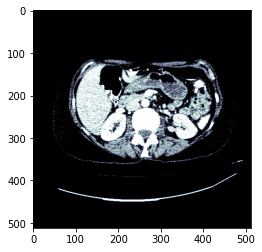

In [ ]:
# Preprocess the nii file
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')

    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')

    plt.show()


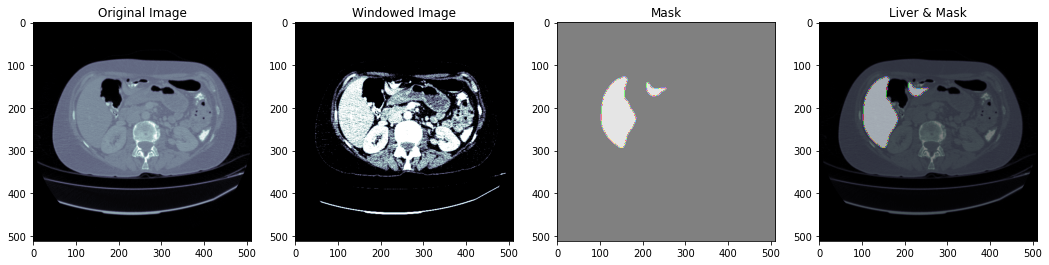

In [ ]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [ ]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252712]
 [     1   9432]]


<AxesSubplot:>

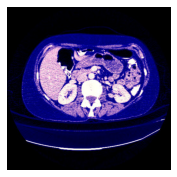

In [ ]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))


@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])


In [ ]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if (GENERATE_JPG_FILES) :

    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:

    path = Path("/content/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/2 [00:00<?, ?it/s]

# **Training**

In [ ]:
bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])

def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')

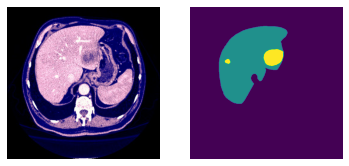

In [ ]:
idx=110
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) #, cmap='gray'

In [ ]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[     0 224096]
 [     1  34793]
 [     2   3255]]


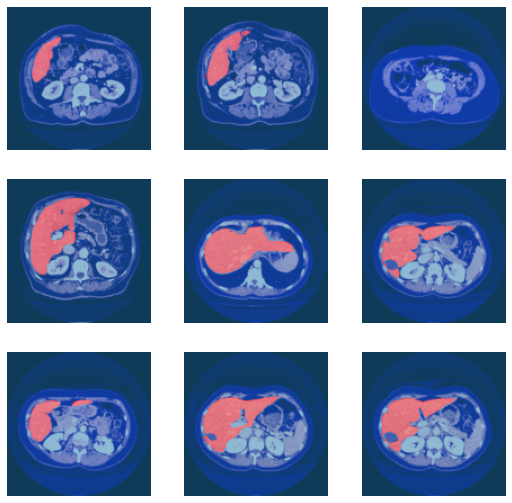

In [ ]:
dls = db.dataloaders(path/'train_images',bs = bs) #, num_workers=0
dls.show_batch()

In [ ]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
'''learn = unet_learner(dls,
                     resnet50,
                     loss_func=CrossEntropyLossFlat(axis=1),
                     metrics=[foreground_acc, cust_foreground_acc]) '''

'learn = unet_learner(dls,\n                     resnet50,\n                     loss_func=CrossEntropyLossFlat(axis=1),\n                     metrics=[foreground_acc, cust_foreground_acc]) '

In [ ]:
learn.fine_tune(1, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,1.188856,0.695724,0.897371,0.868289,01:58


Better model found at epoch 0 with valid_loss value: 0.6957238912582397.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.812090,0.308827,0.239409,0.943983,02:04


Better model found at epoch 0 with valid_loss value: 0.30882659554481506.


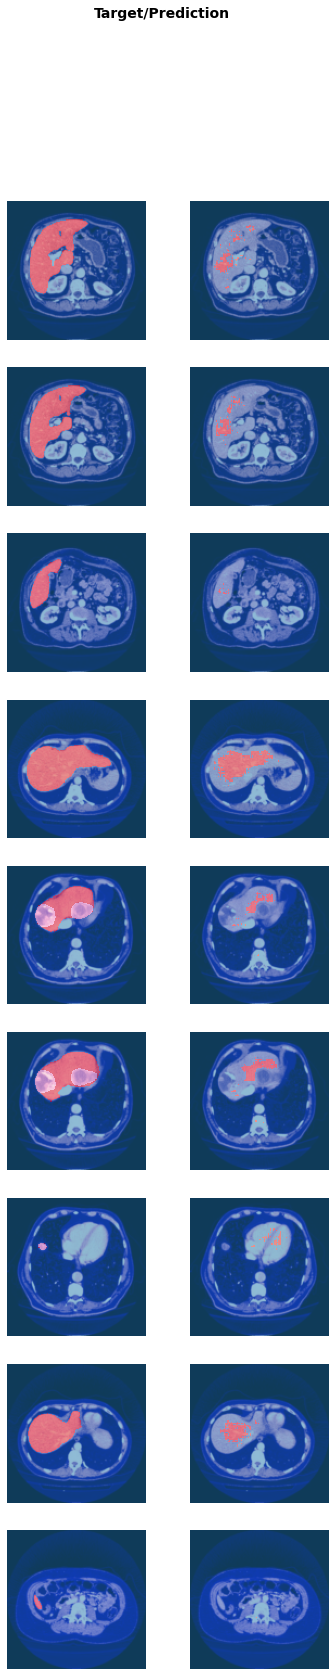

In [ ]:
learn.show_results()


In [ ]:
# Save the model
learn.export(path/f'Liver_segmentation')

# **Testing**

In [ ]:
# Load saved model
if (GENERATE_JPG_FILES) :

    tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
    learn0               = load_learner(path/f'Liver_segmentation',cpu=False )
    learn0.dls.transform = tfms

In [ ]:
def nii_tfm(fn,wins):

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []

    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))

    return slices

(512, 512, 125)


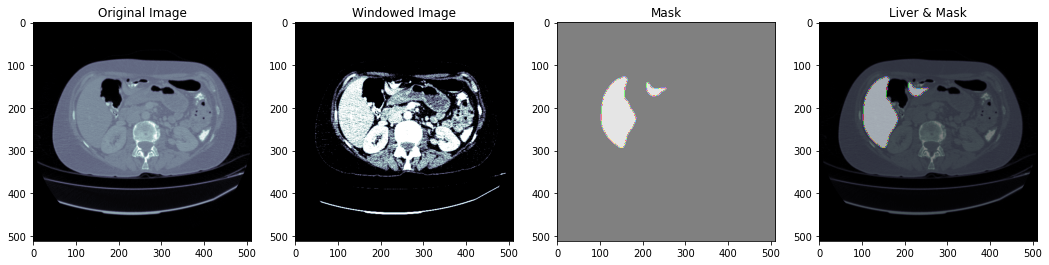

In [ ]:
tst = 1

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 50

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

plt.imsave('f.png', [test_mask[...,test_slice_idx]])

In [ ]:
# Prepare a nii test file for prediction

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ",len(test_files))

Number of test slices:  125


<AxesSubplot:>

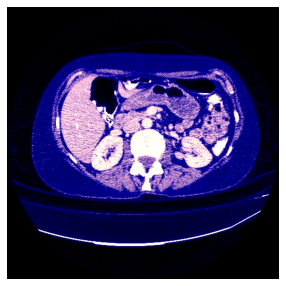

In [ ]:
# Check an input for a test file
show_image(test_files[test_slice_idx])

In [ ]:
!pip install cvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 43.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for cvlib: filename=cvlib-0.2.7-py3-none-any.whl size=10046383 sha256=dab2281a92c18e666b023a5cadfc85f41846bb996ba01bc695090542cfb092ba
  Stored in directory: /root/.cache/pip/wheels/96/ad/4c/d80d4bf4143c154ab297e2384915c89aff43d77d1787b9a702
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12081 sha256=02d6309365be6a655763a0b5c66be0faa7445cf4f4d136cac0bb445793a0ac00
  Stored in directory: /root/.cache/pip/wheels/d7/d9/89/a3f31c76ff6d51dc3b1575628f59afe59e4ceae3f2748cd7ad
Successfully built cvlib progressbar


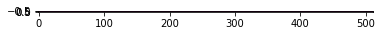

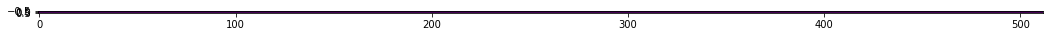

Number of objects in this image are 0


In [ ]:
# هنا اللي زودته!!!!!!!
#!pip install cvlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox
from numpy.lib.polynomial import poly
import imageio as m

img = cv2.imread('f.png')
plt.imshow(img)
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18,15))
#plt.axis('off')
plt.imshow(img1, cmap='gray')
box, label, count = cv.detect_common_objects(img1)
output = draw_bbox(img, box, label, count)
plt.show()

print("Number of objects in this image are " +str(len(label)))

In [ ]:
#!pip install scipy
import imageio as m
def picture_to_arr(image):
        arr = m.imread(image)
        arr_list=arr.tolist()
        r=g=b=0
        for row in arr_list:
            for item in row:
                r=r+item[0]
                g=g+item[1]
                b=b+item[2]
        total=r+g+b
        red=r/total*100
        green=g/total*100
        blue=b/total*100

        y = b-g
        yellow=y/total*100

        #print ("the percentage of red content=",red,"%")
        print ("the percentage of green content=",green,"%")
        print ("the percentage of blue content=",blue,"%")
        print ("the percentage of yellow content=",yellow,"%")


picture_to_arr('f.png')

the percentage of green content= 0.6535947712418301 %
the percentage of blue content= 54.90196078431373 %
the percentage of yellow content= 54.248366013071895 %


In [ ]:
# هنا اللي زودته!!!!!!!

# USAGE
# python object_size.py --image images/example_01.png --width 0.955
# python object_size.py --image images/example_02.png --width 0.955
# python object_size.py --image images/example_03.png --width 3.5

# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,	help="path to the input image")
ap.add_argument("-w", "--width", type=float, required=True,	help="width of the left-most object in the image (in inches)")
args = vars(ap.parse_args())

# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread('f.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

# loop over the contours individually
for c in cnts:
	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue

	# compute the rotated bounding box of the contour
	orig = image.copy()
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")

	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
	box = perspective.order_points(box)
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

	# loop over the original points and draw them
	for (x, y) in box:
		cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

	# unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
	(tl, tr, br, bl) = box
	(tltrX, tltrY) = midpoint(tl, tr)
	(blbrX, blbrY) = midpoint(bl, br)

	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
	(tlblX, tlblY) = midpoint(tl, bl)
	(trbrX, trbrY) = midpoint(tr, br)

	# draw the midpoints on the image
	cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

	# draw lines between the midpoints
	cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 2)
	cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 2)

	# compute the Euclidean distance between the midpoints
	dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
	dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

	# if the pixels per metric has not been initialized, then
	# compute it as the ratio of pixels to supplied metric
	# (in this case, inches)
	if pixelsPerMetric is None:
		pixelsPerMetric = dB / args["width"]

	# compute the size of the object
	dimA = dA / pixelsPerMetric
	dimB = dB / pixelsPerMetric

	# draw the object sizes on the image
	cv2.putText(orig, "{:.1f}in".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	cv2.putText(orig, "{:.1f}in".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)

	# show the output image
	cv2.imshow("Image", orig)
	cv2.waitKey(0)


usage: ipykernel_launcher.py [-h] -i IMAGE -w WIDTH
ipykernel_launcher.py: error: the following arguments are required: -i/--image, -w/--width


SystemExit: ignored

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
image = cv2.imread('filename')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# (thresh, blackAndWhiteImage) = cv2.threshold(gray, 127, 255,
cv2.THRESH_BINARY
plt.imshow(gray, cmap='gray')
blur = cv2.GaussianBlur(gray, (11, 11), 0)
plt.imshow(blur, cmap='gray')
canny = cv2.Canny(blur, 30, 40, 3)
plt.imshow(canny, cmap='gray')
dilated = cv2.dilate(canny, (1, 1), iterations=0)
plt.imshow(dilated, cmap='gray')
(cnt, hierarchy) = cv2.findContours(
dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)
plt.imshow(rgb)
print("No of circles: ", len(cnt))

error: ignored

In [ ]:
# Get predictions for a Test file
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox
from numpy.lib.polynomial import poly
count = 0

test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)
plt.imshow(predicted_mask[test_slice_idx])

predicted= io.imread("predicted_mask")
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
predicted[preds==1] = (0,255,150)
axs[count][0].imshow(predicted)
axs[count][0].title.set_text('CT with AI PREDICTED MASK')
count +=1
box, label, count = cv.detect_common_objects(predicted)
Output = draw_bbox(predicted, box, label, count)

print("Number of objects in this image are " +str(len(label)))



In [ ]:
a=np.array(predicted_mask[test_slice_idx])
np.amin(a),np.amax(a),